# True Random Number Generator using Digital Camera Noise

This is a prototype of a random number generator that uses entropy from digital photos, following [Rongzhong Li, 2015]. The paper is neither entirely reproduced, nor seriously augmented. Rather, this is a quick proof of concept.

In [93]:
from PIL import Image
from glob import glob
from matplotlib import pyplot as plt
%matplotlib inline

import numpy as np
import rawpy

## Photo types and sources

We use several cameras and settings: a Canon 550D DSLR, an iPhone 8 and an iPhone 5s to prove the approach to be stable using different camera models. We also check the approach against raw/processed and closed lens/casual photos. The closed lens case should expose more sensor/reading noise, while in a casual setting, photon shot noise is expected.

In [3]:
def load_photos_from_folder(folder, fmt='jpg', postprocess=True, grayscale=True):
    images = []
    
    if folder[-1] != '/':
        folder = folder + '/'

    glob_string_small = f'{folder}*.{fmt}'
    glob_string_caps = f'{folder}*.{fmt.upper()}'

    for path in glob(glob_string_small) + glob(glob_string_caps):
        if fmt in ('jpg', 'png'):
            image = Image.open(path)
            if grayscale:
                image = image.convert('L')
            image = np.array(image, dtype=np.uint8)
        elif fmt in ('dng', 'cr2'):
            image = rawpy.imread(path)
            if postprocess:
                image = image.postprocess()
                if grayscale:
                    image = 0.2126 * image[:, :, 0] + 0.7152 * image[:, :, 1] + 0.0722 * image[:, :, 2]
        else:
            raise ValueError
        images.append(image)

    return np.array(images)

First, I will process a set of 40 static photos from a DSLR camera in a lit setting. The scene and camera settings are identical.

In [4]:
photos = load_photos_from_folder('../photos/dslr_static/')

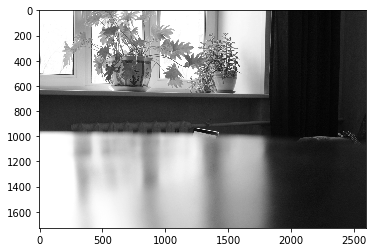

In [5]:
plt.imshow(photos[0], cmap='gray')
plt.show()

Since we'd like to have as much entropy as possible, we'd like to remove bias coming from different sources. 

The first source of bias is over- and underexposed pixels. In overly dark regions, pixels tend not to generate noise, because they do not get activated. In overly bright regions, brightness is clipped to 255, which always has 1 as the last bit.

We also assume that unbiased pixels' mean of last bit deviates by no more than 0.005 from 0.5.

In [27]:
def pixel_statistics(photos):
    mean = np.round(np.mean(photos, axis=0))
    std = np.std(photos, axis=0)
    last_bit_mean = np.mean(photos & 1, axis=0)
    return mean, std, last_bit_mean

In [94]:
mean, std, last_bit_mean = pixel_statistics(photos)
# mask = (last_bit_mean <= 0.53) & (last_bit_mean >= 0.47)

mean = mean.reshape(-1)
std = std.reshape(-1)
last_bit_mean = last_bit_mean.reshape(-1)

# mean = mean[(last_bit_mean <= 0.53) & (last_bit_mean >= 0.47)]
# std = std[(last_bit_mean <= 0.53) & (last_bit_mean >= 0.47)]
# last_bit_mean = last_bit_mean[(last_bit_mean <= 0.53) & (last_bit_mean >= 0.47)]

In [74]:
seq = (photos[5][mask] & 1)[:1151 ** 2].reshape(1151, 1151).T
# seq = bitarray((photos[5][mask] & 1)[:1151 ** 2].reshape(1151, 1151).T.reshape(-1).tolist())

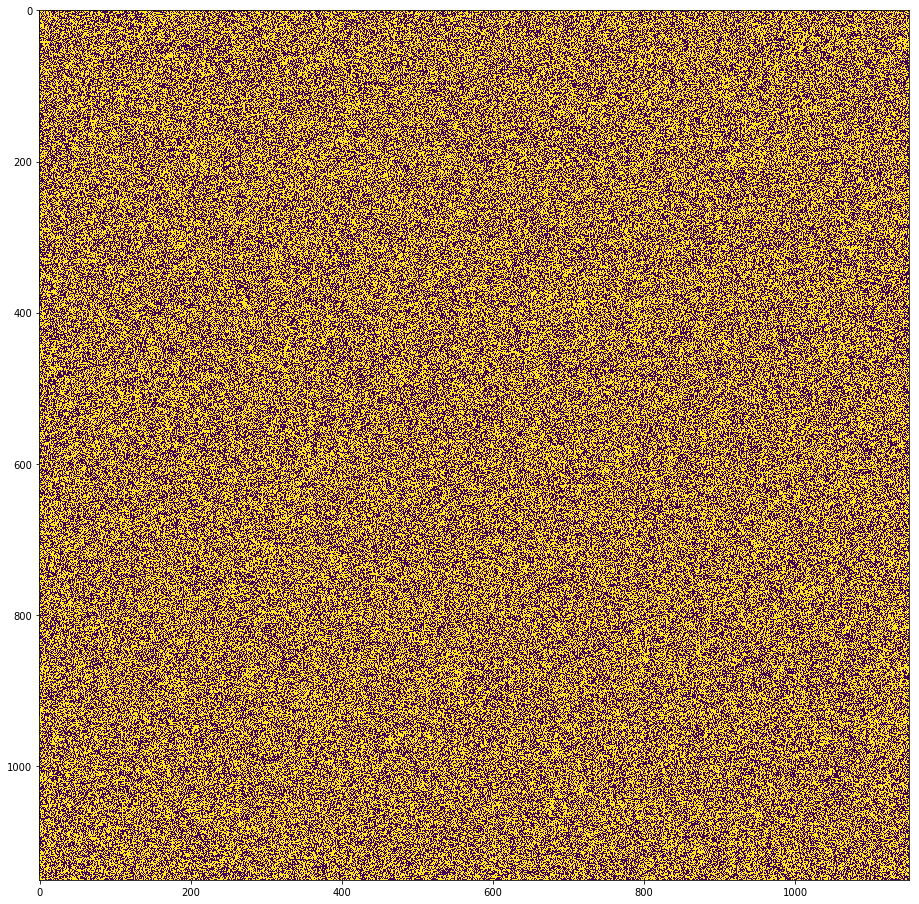

In [77]:
plt.figure(figsize=(16, 16))
plt.imshow(seq)
plt.show()

In [99]:
bitarray('0001011').pop()

True

In [100]:
bitarray().append(True)

In [72]:
seq.tofile(open('seq.bin', 'wb'))

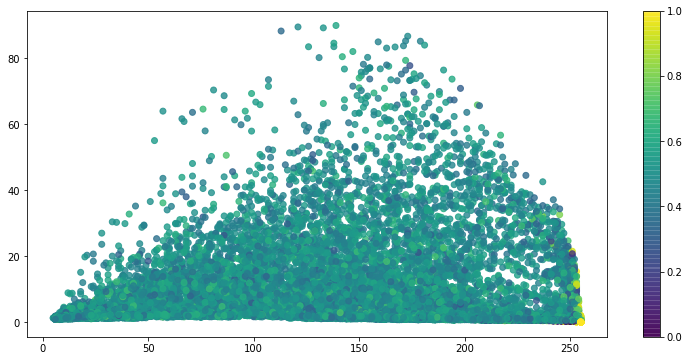

In [97]:
np.random.seed(42)
choice = np.random.choice(np.arange(len(mean)), 50000, replace=False)
plt.figure(figsize=(13, 6))
plt.title('')
plt.scatter(mean[choice], std[choice], c=last_bit_mean[choice], alpha=0.8)
plt.colorbar()
plt.show()

In [ ]:
We see that 